# Fairness Evaluation of UserKNN on the MovieLens 100K Dataset

**Course:** System Development for Marketing  
**Assignment:** Hyperpersonalization – Recommender Systems  
**Model Focus:** User-based Collaborative Filtering (UserKNN)  
**Dataset:** MovieLens 100K  
**Author:** Lucas van der Wielen  
**Date:** 04-04-2025

## Introduction

This notebook presents the implementation and evaluation of a User-based K-Nearest Neighbors (UserKNN) recommender system using the MovieLens 100K dataset. UserKNN is a memory-based collaborative filtering technique that recommends items to a user based on the preferences of similar users.

The goals of this notebook are twofold:

1. **Model Performance**: Train and tune the UserKNN model, and evaluate its prediction accuracy using Root Mean Squared Error (RMSE).
2. **Prepare a Dataset for Fairness Evaluation**: Create a general dataset to use for fairness evaluation across the different models

Gender is selected as the primary sensitive attribute in order to enable consistent comparisons with other datasets like Yelp, which lacks age information. Throughout this notebook, we follow a reproducible pipeline that includes data preprocessing, model training, prediction, and evaluation using both accuracy-based and fairness-based metrics.

## Datasets needed for this Jupyter Notebook:

- `df_full.csv`  
  Preprocessed dataset combining ratings and user/item metadata.

### Importing Libraries and Packages
In this section, we import the necessary libraries and packages that will be used throughout the code for data manipulation, model building, and evaluation.

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Define the path to your CSV file
file_path = r"C:\Users\LucasvanderWielenAlp\OneDrive - Alpine Hearing Protection\Documenten\Master DDB\System Development\Data\df_full.csv"

# Load the CSV file into a DataFrame
df_full = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to check
print(df_full.head())
print(df_full.shape)

   movie_id  user_id  rating            timestamp  age gender  occupation  \
0       242      196       3  1997-12-04 15:55:49   49      M      writer   
1       302      186       3  1998-04-04 19:22:22   39      F   executive   
2       377       22       1  1997-11-07 07:18:36   25      M      writer   
3        51      244       2  1997-11-27 05:02:03   28      M  technician   
4       346      166       1  1998-02-02 05:33:16   47      M    educator   

  zip_code                       title release_date  release_year  
0    55105                Kolya (1996)  24-Jan-1997          1997  
1    00000    L.A. Confidential (1997)  01-Jan-1997          1997  
2    40206         Heavyweights (1994)  01-Jan-1994          1994  
3    80525  Legends of the Fall (1994)  01-Jan-1994          1994  
4    55113         Jackie Brown (1997)  01-Jan-1997          1997  
(99991, 11)


In [3]:
df_full

,movie_id,user_id,rating,timestamp,age,gender,occupation,zip_code,title,release_date,release_year
0,242,196,3,1997-12-04 15:55:49,49,M,writer,55105,Kolya (1996),24-Jan-1997,1997
1,302,186,3,1998-04-04 19:22:22,39,F,executive,00000,L.A. Confidential (1997),01-Jan-1997,1997
2,377,22,1,1997-11-07 07:18:36,25,M,writer,40206,Heavyweights (1994),01-Jan-1994,1994
3,51,244,2,1997-11-27 05:02:03,28,M,technician,80525,Legends of the Fall (1994),01-Jan-1994,1994
4,346,166,1,1998-02-02 05:33:16,47,M,educator,55113,Jackie Brown (1997),01-Jan-1997,1997
...,...,...,...,...,...,...,...,...,...,...,...
99986,476,880,3,1997-11-22 05:10:44,13,M,student,83702,"First Wives Club, The (1996)",14-Sep-1996,1996
99987,204,716,5,1997-11-17 19:39:03,36,F,administrator,44265,Back to the Future (1985),01-Jan-1985,1985
99988,1090,276,1,1997-09-20 22:49:55,21,M,student,95064,Sliver (1993),01-Jan-1993,1993
99989,225,13,2,1997-12-17 22:52:36,47,M,educator,29206,101 Dalmatians (1996),27-Nov-1996,1996


In [4]:
# Create the full user-item matrix
user_item_matrix = df_full.pivot_table(index='user_id', columns='movie_id', values='rating')

# Create empty train/test matrices
train_matrix = user_item_matrix.copy() * np.nan
test_matrix = user_item_matrix.copy() * np.nan

# User-wise split: 80% train, 20% test
for user_id in user_item_matrix.index:
    user_ratings = user_item_matrix.loc[user_id].dropna()
    if len(user_ratings) < 5:  # Optional: skip users with very few ratings
        continue
    shuffled = user_ratings.sample(frac=1, random_state=42)
    cutoff = int(0.8 * len(shuffled))
    train_items = shuffled.iloc[:cutoff]
    test_items = shuffled.iloc[cutoff:]

    train_matrix.loc[user_id, train_items.index] = train_items.values
    test_matrix.loc[user_id, test_items.index] = test_items.values

# Convert train/test matrices back to long-format DataFrames
df_train = train_matrix.stack().reset_index()
df_train.columns = ['user_id', 'movie_id', 'rating']

df_test = test_matrix.stack().reset_index()
df_test.columns = ['user_id', 'movie_id', 'rating']

# Now df_train and df_test both contain all users and all movies
print("Train users:", df_train['user_id'].nunique())
print("Test users: ", df_test['user_id'].nunique())
print("Train movies:", df_train['movie_id'].nunique())
print("Test movies: ", df_test['movie_id'].nunique())

Train users: 943
Test users:  943
Train movies: 1617
Test movies:  1480


In [5]:
# Build check matrices from df_full
full_matrix = df_full.pivot_table(index='user_id', columns='movie_id', values='rating')

# Rebuild train and test from df_train and df_test
train_matrix_check = full_matrix.copy() * np.nan
test_matrix_check = full_matrix.copy() * np.nan

for _, row in df_train.iterrows():
    train_matrix_check.loc[row['user_id'], row['movie_id']] = row['rating']

for _, row in df_test.iterrows():
    test_matrix_check.loc[row['user_id'], row['movie_id']] = row['rating']

# Now do your validations
original_count = (~full_matrix.isna()).sum().sum()
train_count = (~train_matrix_check.isna()).sum().sum()
test_count = (~test_matrix_check.isna()).sum().sum()
overlap_matrix = (~train_matrix_check.isna()) & (~test_matrix_check.isna())
overlap_count = overlap_matrix.sum().sum()

print("\nDOUBLE CHECK:")
print(f"Original rating count: {original_count}")
print(f"Train rating count:    {train_count}")
print(f"Test rating count:     {test_count}")
print(f"Total (train + test):  {train_count + test_count}")
print("Rating count preserved:", original_count == train_count + test_count)
print(f"Overlapping ratings in train and test: {overlap_count}")
print("No overlap between train and test:", overlap_count == 0)



DOUBLE CHECK:
Original rating count: 99991
Train rating count:    79610
Test rating count:     20381
Total (train + test):  99991
Rating count preserved: True
Overlapping ratings in train and test: 0
No overlap between train and test: True


In [6]:
# Build train matrix and compute similarity
# Pivot the training data into a user-item matrix
user_item_matrix = df_train.pivot_table(index='user_id', columns='movie_id', values='rating')
user_item_matrix_filled = user_item_matrix.fillna(0)  # Fill NaNs with 0 for cosine similarity

# Compute cosine similarity between users based on rating vectors
user_similarity = cosine_similarity(user_item_matrix_filled)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

In [7]:
# Prediction function using UserKNN with top-k similar users
def predict_rating(user_id, movie_id, k):
    if movie_id not in user_item_matrix.columns:
        return np.nan

    # Find users who rated the target movie
    movie_ratings = user_item_matrix[movie_id].dropna()
    if user_id not in user_similarity_df.index or movie_ratings.empty:
        return np.nan

    # Extract similarity scores for those users
    sims = user_similarity_df.loc[user_id, movie_ratings.index]

    # Combine similarities and corresponding ratings
    neighbors = pd.DataFrame({
        'similarity': sims,
        'rating': movie_ratings
    })

    # Select top-k similar users
    top_k = neighbors.sort_values('similarity', ascending=False).head(k)
    if top_k['similarity'].sum() == 0:
        return np.nan

    # Return the weighted average of ratings
    return np.dot(top_k['rating'], top_k['similarity']) / top_k['similarity'].sum()

# Grid search to find best k based on RMSE
k_values = [5, 10, 15, 20, 30, 40, 50]  # Try different values for k
results = []

# For each value of k, evaluate predictions on the test set
for k in k_values:
    actual, predicted = [], []

    for _, row in df_test.iterrows():
        pred = predict_rating(row['user_id'], row['movie_id'], k)
        if not np.isnan(pred):
            actual.append(row['rating'])
            predicted.append(pred)

    if predicted:
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        results.append((k, rmse))
        print(f"k={k}, RMSE={rmse:.4f}")
    else:
        print(f"k={k}, No predictions made.")

# Select the best k value with lowest RMSE
best_k, best_rmse = min(results, key=lambda x: x[1])
print(f"\n Best k: {best_k} with RMSE: {best_rmse:.4f}")

# Re-evaluate using the best k for reporting
final_actual, final_predicted = [], []

for _, row in df_test.iterrows():
    pred = predict_rating(row['user_id'], row['movie_id'], best_k)
    if not np.isnan(pred):
        final_actual.append(row['rating'])
        final_predicted.append(pred)

# Compute final RMSE
final_rmse = np.sqrt(mean_squared_error(final_actual, final_predicted))
print(f"\n Final RMSE with best k={best_k}: {final_rmse:.4f}")

k=5, RMSE=1.0591
k=10, RMSE=1.0286
k=15, RMSE=1.0200
k=20, RMSE=1.0156
k=30, RMSE=1.0130
k=40, RMSE=1.0127
k=50, RMSE=1.0126

 Best k: 50 with RMSE: 1.0126

 Final RMSE with best k=50: 1.0126


In [10]:
# Create predictions dataframe for further analysis
userknn_preds_df = df_test.copy()
userknn_preds_df['predicted_rating'] = userknn_preds_df.apply(
    lambda row: predict_rating(row['user_id'], row['movie_id'], best_k), axis=1
)
userknn_preds_df = userknn_preds_df.rename(columns={'rating': 'true_rating'})


RMSE for male users (UserKNN):   0.9855
RMSE for female users (UserKNN): 1.0869


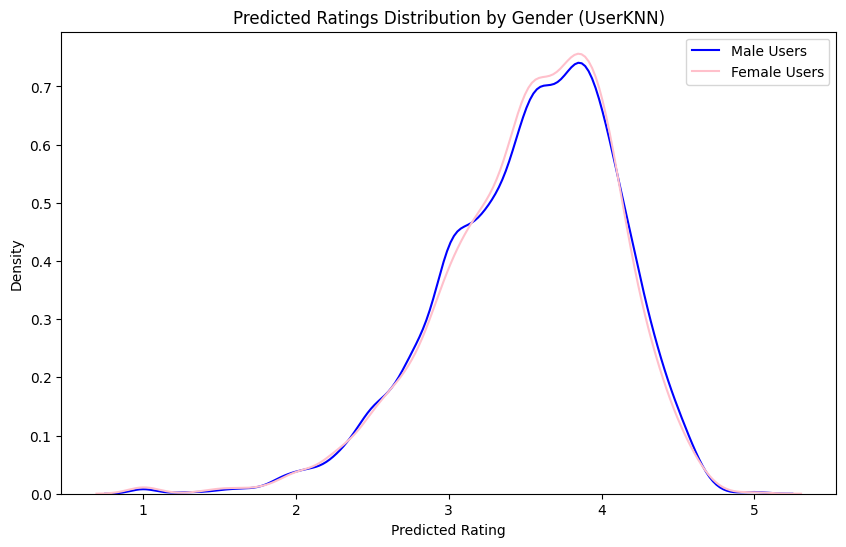

In [11]:
# Extract gender info
df_gender_comparison = df_full[['user_id', 'gender']].drop_duplicates()

# Merge gender with predictions
userknn_gender_df = pd.merge(userknn_preds_df, df_gender_comparison, on='user_id', how='inner')

# Split by gender
male_preds = userknn_gender_df[userknn_gender_df['gender'] == 'M']
female_preds = userknn_gender_df[userknn_gender_df['gender'] == 'F']

# Calculate RMSE for each group
male_rmse = ((male_preds['true_rating'] - male_preds['predicted_rating'])**2).mean() ** 0.5
female_rmse = ((female_preds['true_rating'] - female_preds['predicted_rating'])**2).mean() ** 0.5

print(f"RMSE for male users (UserKNN):   {male_rmse:.4f}")
print(f"RMSE for female users (UserKNN): {female_rmse:.4f}")

# Optional: Plot distribution of predicted ratings by gender
plt.figure(figsize=(10, 6))
sns.kdeplot(male_preds['predicted_rating'], label='Male Users', color='blue')
sns.kdeplot(female_preds['predicted_rating'], label='Female Users', color='pink')
plt.title("Predicted Ratings Distribution by Gender (UserKNN)")
plt.xlabel("Predicted Rating")
plt.ylabel("Density")
plt.legend()
plt.show()


In [8]:
# Create an empty list to collect prediction rows
userknn_preds = []

# Loop through the test set and collect predictions for UserKNN
for _, row in df_test.iterrows():
    user = row['user_id']
    movie = row['movie_id']
    actual = row['rating']

    pred = predict_rating(user, movie, best_k)  # <-- UserKNN prediction function

    if not np.isnan(pred):
        userknn_preds.append({
            'user_id': user,
            'movie_id': movie,
            'actual_rating': actual,
            'predicted_rating': pred,
            'model': 'userknn'
        })

# Convert to DataFrame
df_userknn_preds = pd.DataFrame(userknn_preds)

# Quick check
print(df_userknn_preds.head())
print(f"\nTotal predictions made by UserKNN: {len(df_userknn_preds)}")

# saved and used for fairness metrics


   user_id  movie_id  actual_rating  predicted_rating    model
0      1.0       9.0            5.0          4.145727  userknn
1      1.0      14.0            5.0          3.811094  userknn
2      1.0      15.0            5.0          3.579159  userknn
3      1.0      18.0            4.0          3.012525  userknn
4      1.0      21.0            1.0          2.733760  userknn

Total predictions made by UserKNN: 20303
